In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import matplotlib.pyplot as plt

In [2]:
# produced by the notebook "classify all features extracted from all the runs"
SEQUENCES_WITH_SPECIES_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/sequences-with-species-df.pkl'
# copied from BAM
MAPPING_FILE_NAME = "/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/recalibrated-percolator-output/percolator-idx-mapping.csv"
EXPERIMENT_METRICS_FILE_NAME = "/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/target-decoy-models/experiment-metrics-for-library-sequences.pkl"


In [3]:
MAPPING_FILE_NAME = "/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/recalibrated-percolator-output/percolator-idx-mapping.csv"

# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result

In [4]:
# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

In [5]:
get_percolator_run_mapping(MAPPING_FILE_NAME)

[(0, '190719_Hela_Ecoli_1to3_06'),
 (1, '190719_Hela_Ecoli_1to1_07'),
 (2, '190719_Hela_Ecoli_1to1_09'),
 (3, '190719_Hela_Ecoli_1to3_09'),
 (4, '190719_Hela_Ecoli_1to3_05'),
 (5, '190719_Hela_Ecoli_1to3_01'),
 (6, '190719_Hela_Ecoli_1to1_03'),
 (7, '190719_Hela_Ecoli_1to3_08'),
 (8, '190719_Hela_Ecoli_1to1_10'),
 (9, '190719_Hela_Ecoli_1to3_07'),
 (10, '190719_Hela_Ecoli_1to1_08'),
 (11, '190719_Hela_Ecoli_1to1_01'),
 (12, '190719_Hela_Ecoli_1to3_04'),
 (13, '190719_Hela_Ecoli_1to3_03'),
 (14, '190719_Hela_Ecoli_1to3_10'),
 (15, '190719_Hela_Ecoli_1to1_04'),
 (16, '190719_Hela_Ecoli_1to1_02'),
 (17, '190719_Hela_Ecoli_1to3_02'),
 (18, '190719_Hela_Ecoli_1to1_05'),
 (19, '190719_Hela_Ecoli_1to1_06')]

In [6]:
sequences_with_species_df = pd.read_pickle(SEQUENCES_WITH_SPECIES_FILE_NAME)
sequences_with_species_df.drop(['intensity'], axis=1, inplace=True)

In [7]:
len(sequences_with_species_df)

17697

In [8]:
experiment_metrics_for_library_sequences_df = pd.read_pickle(EXPERIMENT_METRICS_FILE_NAME)

In [40]:
experiment_metrics_for_library_sequences_df.columns

Index(['sequence', 'charge', 'theoretical_mz', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'experiment_scan_peak_width',
       'experiment_rt_mean', 'experiment_rt_std_dev',
       'experiment_rt_peak_width', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'number_of_runs_identified', 'q_value',
       'file_idx', 'target_coords', 'decoy_coords', 'target_metrics',
       'attributes', 'decoy_metrics'],
      dtype='object')

In [9]:
len(experiment_metrics_for_library_sequences_df)

20000

In [10]:
sequences_with_species_df.sample(2)

,sequence,charge,file_idx,classed_as,run_name,batch,human
15172,ESSLTLTHEQR,2,6,target,190719_Hela_Ecoli_1to1_03,1to1,False
2204,MLDILAEYLK,2,13,target,190719_Hela_Ecoli_1to3_03,1to3,True


In [11]:
# unpack the TFD-extracted attributes from each sequence
attributes = []
attribute_names = [key for key in sorted(experiment_metrics_for_library_sequences_df.iloc[0].attributes)]

for row in experiment_metrics_for_library_sequences_df.itertuples():
    # target metric valuesa
    d = row.attributes
    if (d is not None):
        # check whether any of the values are None
        all_not_none = True
        for k,v in d.items(): 
            if d[k] is None:
                all_not_none = False
                break
        # add the attributes to the collection
        if all_not_none == True:
            l = []
            l.append(row.sequence)
            l.append(row.charge)
            l.append(row.file_idx)
            l += [d[key] for key in sorted(d)]
            attributes.append(tuple(l))

columns = ['sequence','charge','file_idx']
columns += attribute_names

attributes_as_extracted_df = pd.DataFrame(attributes, columns=columns)

In [12]:
len(attributes_as_extracted_df)

19230

In [13]:
attributes_as_extracted_df.sample(5)

,sequence,charge,file_idx,inferred,intensity,isotope_idx_not_in_saturation,isotope_intensities_l,monoisotopic_mz,rt_apex,scan_apex
4316,MLEDSESSYEPDELTK,2,4,0,373,0,"[(373.0, False, [(936.9020038591441, 315.0, 52...",936.904749,553.314080,332.309455
1657,ENLESWLNYLK,2,1,0,5068,0,"[(5068.0, False, [(704.8565342052782, 595.0, 9...",704.858705,983.262798,603.493173
8540,IDSDDALNHDFFWSDPMPSDLK,3,8,0,602,0,"[(602.0, False, [(855.7075446095944, 658.0, 85...",855.709886,913.652119,667.000000
2929,ISIEMNGTLEDQLSHLK,3,3,0,3234,0,"[(3234.0, False, [(643.3285900684878, 796.0, 7...",643.330924,806.697257,802.984839
13386,MTESFAQLFEESLK,2,13,1,30559,3,"[(24147.0, True, [(830.3968835192388, 403.0, 9...",830.400470,1016.282799,415.603099


In [14]:
attributes_as_extracted_df.columns

Index(['sequence', 'charge', 'file_idx', 'inferred', 'intensity',
       'isotope_idx_not_in_saturation', 'isotope_intensities_l',
       'monoisotopic_mz', 'rt_apex', 'scan_apex'],
      dtype='object')

In [15]:
sequences_with_species_df[(sequences_with_species_df.sequence == 'ALTLQDLDNIWAAQAGK') & (sequences_with_species_df.charge == 2)]

,sequence,charge,file_idx,classed_as,run_name,batch,human


In [16]:
sequences_with_species_df.sample(5)

,sequence,charge,file_idx,classed_as,run_name,batch,human
9288,LAILGIHNEVSK,2,11,target,190719_Hela_Ecoli_1to1_01,1to1,True
11814,WADLLSSESWQEVLDK,2,19,target,190719_Hela_Ecoli_1to1_06,1to1,False
9170,DPEAGDVEADPGLADLPQQLLFVHQGETELK,3,9,target,190719_Hela_Ecoli_1to3_07,1to3,True
394,TESNQEVANPEHYIK,2,5,target,190719_Hela_Ecoli_1to3_01,1to3,True
1793,EWAHATIIPK,2,15,target,190719_Hela_Ecoli_1to1_04,1to1,True


In [17]:
sequences_with_attributes_df = pd.merge(attributes_as_extracted_df, sequences_with_species_df, how='inner', left_on=['sequence','charge','file_idx'], right_on=['sequence','charge','file_idx'])

In [18]:
len(sequences_with_attributes_df)

17630

In [19]:
sequences_with_attributes_df.columns

Index(['sequence', 'charge', 'file_idx', 'inferred', 'intensity',
       'isotope_idx_not_in_saturation', 'isotope_intensities_l',
       'monoisotopic_mz', 'rt_apex', 'scan_apex', 'classed_as', 'run_name',
       'batch', 'human'],
      dtype='object')

In [20]:
sequences_with_attributes_df['log_intensity'] = np.log2(sequences_with_attributes_df.intensity)

In [21]:
sequences_with_attributes_df.columns

Index(['sequence', 'charge', 'file_idx', 'inferred', 'intensity',
       'isotope_idx_not_in_saturation', 'isotope_intensities_l',
       'monoisotopic_mz', 'rt_apex', 'scan_apex', 'classed_as', 'run_name',
       'batch', 'human', 'log_intensity'],
      dtype='object')

In [22]:
# find the experiment-wide means and std devs
experiment_intensities_l = []
for group_name,group_df in sequences_with_attributes_df.groupby(['sequence','charge'], as_index=False):
    number_of_runs_for_sequence = len(group_df)
    # intensity
    experiment_intensity_mean = np.mean(group_df.log_intensity)
    experiment_intensity_std_dev = np.std(group_df.log_intensity)
    # rt
    experiment_rt_mean = np.mean(group_df.rt_apex)
    experiment_rt_std_dev = np.std(group_df.rt_apex)
    # scan
    experiment_scan_mean = np.mean(group_df.scan_apex)
    experiment_scan_std_dev = np.std(group_df.scan_apex)
    # sequence and charge
    sequence = group_name[0]
    charge = group_name[1]
    experiment_intensities_l.append((sequence,charge,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence))

experiment_intensities_df = pd.DataFrame(experiment_intensities_l, columns=['sequence','charge','experiment_intensity_mean','experiment_intensity_std_dev','experiment_rt_mean','experiment_rt_std_dev','experiment_scan_mean','experiment_scan_std_dev','number_of_runs_for_sequence'])


In [23]:
sequences_df = pd.merge(sequences_with_attributes_df, experiment_intensities_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])


In [24]:
len(sequences_df)

17630

In [25]:
len(sequences_df[sequences_df.human == False])

3624

#### use this sample of e.coli sequences that occur in a majority of the runs to analyse the intensity consistency

In [26]:
sequences_df[(sequences_df.number_of_runs_for_sequence > 15) & (sequences_df.human == False)].sample(10).sort_values(by=['intensity','sequence','charge'], ascending=False, inplace=False)


,sequence,charge,file_idx,inferred,intensity,isotope_idx_not_in_saturation,isotope_intensities_l,monoisotopic_mz,rt_apex,scan_apex,...,batch,human,log_intensity,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence
1021,GNTGENLLALLEGR,2,1,1,22036,2,"[(22350.0, True, [(728.888771421461, 591.0, 94...",728.892121,1006.204106,603.412544,...,1to1,False,14.427575,15.085338,0.579158,1004.910899,4.191721,596.874737,7.586322,20
6921,LPLTLDPVR,2,7,1,14368,1,"[(14565.0, True, [(512.3127086630748, 846.0, 8...",512.312709,889.780019,854.146330,...,1to3,False,13.810572,12.843629,1.037039,891.251786,18.857147,853.518028,2.514462,17
12077,EGVCGSDGLNMNGK,2,13,1,9151,1,"[(8969.0, True, [(719.3056904356715, 616.0, 35...",719.308920,377.746914,625.287478,...,1to3,False,13.159714,12.510593,1.184079,379.237522,2.779933,630.398289,4.311655,20
2211,EQLLEVGDFLK,2,2,0,4221,0,"[(4221.0, False, [(645.8488387342458, 674.0, 8...",645.848839,888.507621,683.041107,...,1to1,False,12.043369,10.909415,1.104764,887.099233,3.430355,686.149473,2.926187,20
7302,STFQQLPGTGVKPDQFHSQTR,3,8,0,4038,0,"[(4038.0, False, [(787.0629729972294, 701.0, 4...",787.065249,518.823456,715.442687,...,1to1,False,11.979425,12.398115,0.553688,516.301232,4.099549,716.411629,2.799347,20
12706,FSGNYGNMTEVSYQVAK,2,14,0,2782,0,"[(2782.0, False, [(947.935866063112, 306.0, 56...",947.938117,600.679108,313.999370,...,1to3,False,11.441907,11.142216,0.535030,604.031168,3.332464,311.418388,3.592165,20
4551,VADELAVITCAPFVTAPNK,2,5,0,1258,0,"[(1258.0, False, [(1008.5259900099585, 169.0, ...",1008.529670,899.930556,178.813372,...,1to3,False,10.296916,10.655606,0.507480,898.948033,9.885941,183.959112,9.705483,19
14728,FEDFEIEGYDPHPGIK,2,16,0,895,0,"[(895.0, False, [(946.9367103662164, 238.0, 64...",946.939453,692.510951,252.661150,...,1to1,False,9.805744,9.737965,1.598969,687.805503,2.634585,247.291812,3.788364,20
16983,SNNTEPTWFPDSQNLAFTSDQAGRPQVYK,3,19,0,733,0,"[(733.0, False, [(1100.1846924363776, 408.0, 7...",1100.187380,781.462942,428.148989,...,1to1,False,9.517669,9.616532,0.385566,780.486009,3.636207,433.613912,67.465421,20
10986,VIAFNVNQDISSSMQTLAK,2,12,0,163,0,"[(163.0, False, [(1033.5293404876443, 105.0, 7...",1033.531680,855.072162,115.404729,...,1to3,False,7.348728,8.875706,0.973659,854.460544,2.569814,124.763795,20.121409,19


In [27]:
sequences_df.classed_as.unique()

array(['target'], dtype=object)

In [28]:
selected_sequence = 'VGMGTCQGELCACR'
selected_sequence_charge = 2

In [29]:
selected_sequence_df = sequences_df[(sequences_df.sequence == selected_sequence) & (sequences_df.charge == selected_sequence_charge)].copy()

In [30]:
selected_sequence_df.sort_values(by=['batch','run_name'], inplace=True)

In [31]:
selected_sequence_df

,sequence,charge,file_idx,inferred,intensity,isotope_idx_not_in_saturation,isotope_intensities_l,monoisotopic_mz,rt_apex,scan_apex,...,batch,human,log_intensity,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence
9861,VGMGTCQGELCACR,2,11,0,156,0,"[(156.0, False, [(799.8285930434901, 548.0, 38...",799.830678,408.599333,558.000000,...,1to1,False,7.285402,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20
14254,VGMGTCQGELCACR,2,16,0,3645,0,"[(3645.0, False, [(799.8285540374922, 528.0, 3...",799.830514,417.251846,536.941795,...,1to1,False,11.831703,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20
5516,VGMGTCQGELCACR,2,6,0,275,0,"[(275.0, False, [(799.8285573989439, 548.0, 38...",799.830377,410.151899,538.892912,...,1to1,False,8.103288,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20
13363,VGMGTCQGELCACR,2,15,0,314,0,"[(314.0, False, [(799.828590779191, 530.0, 388...",799.830385,410.431346,527.117600,...,1to1,False,8.294621,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20
16053,VGMGTCQGELCACR,2,18,0,3992,0,"[(3992.0, False, [(799.8285938751997, 533.0, 3...",799.830675,417.199852,536.306847,...,1to1,False,11.962896,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20
16941,VGMGTCQGELCACR,2,19,0,5008,0,"[(5008.0, False, [(799.8285783602244, 527.0, 3...",799.830914,415.295015,534.602056,...,1to1,False,12.290019,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20
1097,VGMGTCQGELCACR,2,1,0,3872,0,"[(3872.0, False, [(799.8330421118716, 517.0, 3...",799.833042,415.350370,533.600592,...,1to1,False,11.918863,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20
9011,VGMGTCQGELCACR,2,10,0,4211,0,"[(4211.0, False, [(799.833022934568, 526.0, 39...",799.833023,415.137313,533.130711,...,1to1,False,12.039947,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20
1970,VGMGTCQGELCACR,2,2,0,4589,0,"[(4589.0, False, [(799.8285508703831, 527.0, 3...",799.830618,414.060928,535.722781,...,1to1,False,12.163964,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20
7281,VGMGTCQGELCACR,2,8,0,4567,0,"[(4567.0, False, [(799.8286040283056, 530.0, 3...",799.830726,415.324736,536.993477,...,1to1,False,12.157031,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20


In [32]:
selected_sequence_df.to_pickle('/Users/darylwilding-mcbride/Downloads/sequence-{}-charge-{}-df.pkl'.format(selected_sequence, selected_sequence_charge))

In [33]:
selected_sequence_1to1_df = selected_sequence_df[selected_sequence_df.batch == '1to1']
selected_sequence_1to3_df = selected_sequence_df[selected_sequence_df.batch == '1to3']

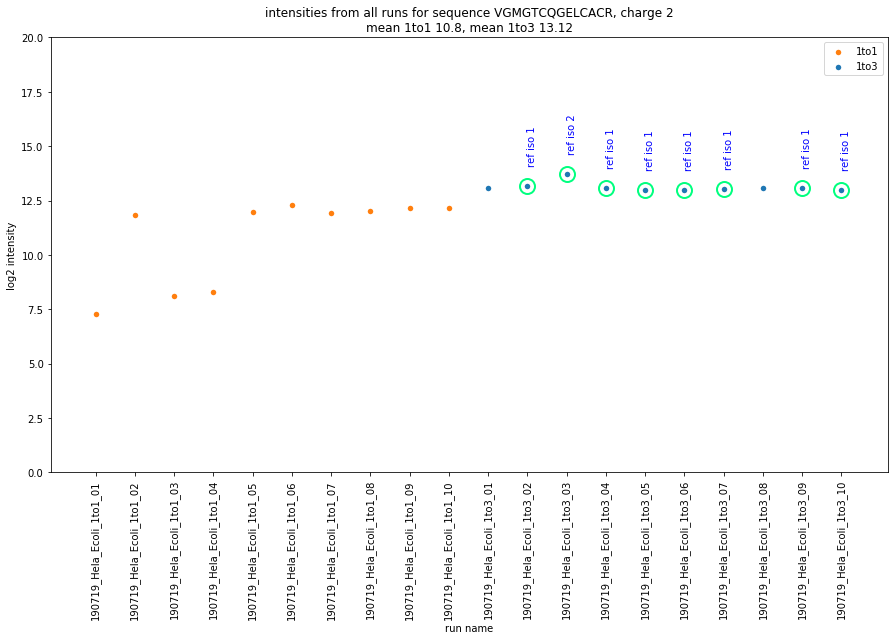

In [34]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

mean_1to1 = round(np.mean(np.log2(selected_sequence_1to1_df.intensity)), 2)
mean_1to3 = round(np.mean(np.log2(selected_sequence_1to3_df.intensity)), 2)

plt.title('intensities from all runs for sequence {}, charge {}\nmean 1to1 {}, mean 1to3 {}'.format(selected_sequence, selected_sequence_charge, mean_1to1, mean_1to3))

ax1.scatter(selected_sequence_1to1_df.run_name, np.log2(selected_sequence_1to1_df.intensity), marker='o', color='tab:orange', lw=0, s=30, alpha=1.0, label='1to1')
ax1.scatter(selected_sequence_1to3_df.run_name, np.log2(selected_sequence_1to3_df.intensity), marker='o', color='tab:blue', lw=0, s=30, alpha=1.0, label='1to3')

# highlight whether a point was adjusted for saturation
adj_sat_1to1 = selected_sequence_1to1_df[(selected_sequence_1to1_df.isotope_idx_not_in_saturation > 0)]
ax1.plot(adj_sat_1to1.run_name, np.log2(adj_sat_1to1.intensity), marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15)

adj_sat_1to3 = selected_sequence_1to3_df[(selected_sequence_1to3_df.isotope_idx_not_in_saturation > 0)]
ax1.plot(adj_sat_1to3.run_name, np.log2(adj_sat_1to3.intensity), marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15)

# show which isotope was used as a reference
text_style = dict(size=10, color='blue')
for idx,row in adj_sat_1to1.iterrows():
    ax1.text(row.run_name, np.log2(row.intensity)+1, "ref iso {}".format(row.isotope_idx_not_in_saturation), **text_style, rotation=90)
for idx,row in adj_sat_1to3.iterrows():
    ax1.text(row.run_name, np.log2(row.intensity)+1, "ref iso {}".format(row.isotope_idx_not_in_saturation), **text_style, rotation=90)

plt.xlabel('run name')
plt.ylabel('log2 intensity')
plt.legend(loc='best')

# plt.xlim((0,50))
plt.ylim((0,20))
plt.xticks(rotation=90)

plt.show()

#### look at the distribution of intensity deltas for sequences in 1to1 runs 01 and 02

In [35]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'inferred', 'intensity',
       'isotope_idx_not_in_saturation', 'isotope_intensities_l',
       'monoisotopic_mz', 'rt_apex', 'scan_apex', 'classed_as', 'run_name',
       'batch', 'human', 'log_intensity', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'experiment_rt_mean',
       'experiment_rt_std_dev', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'number_of_runs_for_sequence'],
      dtype='object')

In [36]:
run_A = '190719_Hela_Ecoli_1to1_01'
run_B = '190719_Hela_Ecoli_1to1_02'
sequences_in_run_01_df = sequences_df[(sequences_df.file_idx == file_idx_for_run(run_A))]
sequences_in_run_02_df = sequences_df[(sequences_df.file_idx == file_idx_for_run(run_B))]

In [37]:
sequences_in_both_runs_df = pd.merge(sequences_in_run_01_df, sequences_in_run_02_df, how='inner', left_on=['sequence','charge'], right_on=['sequence','charge'])


In [38]:
sequences_in_both_runs_df['delta_log_intensity'] = sequences_in_both_runs_df.log_intensity_x - sequences_in_both_runs_df.log_intensity_y

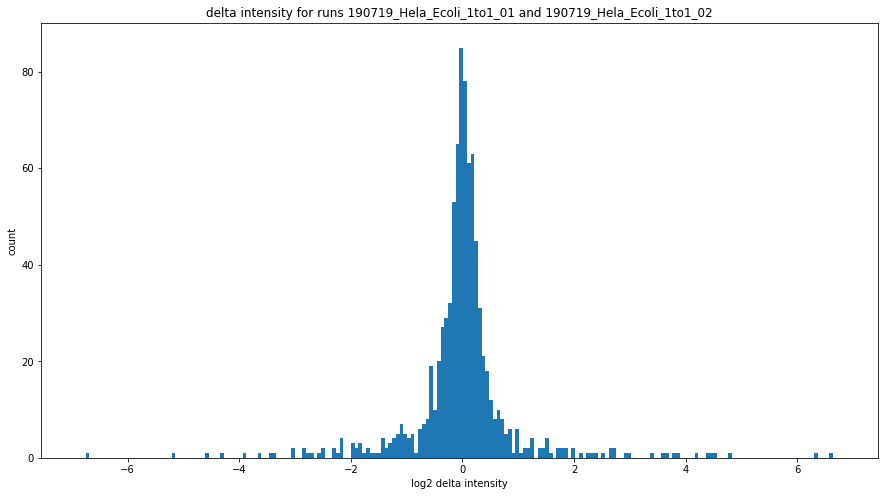

In [39]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 200
hist, bins, _ = plt.hist(sequences_in_both_runs_df.delta_log_intensity, bins=bins)
plt.xlabel('log2 delta intensity')
plt.ylabel('count')
plt.title('delta intensity for runs {} and {}'.format(run_A, run_B))

plt.show()